In [1]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import scipy
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df = df[['default', 'LIMIT_BAL','SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]

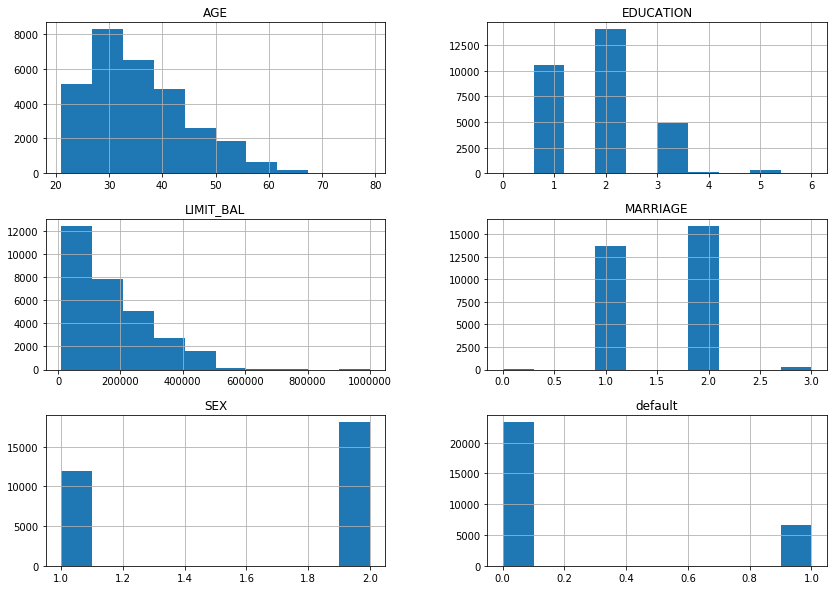

In [6]:
figsize(14,10)
df.hist()
plt.show()

In [7]:
df.shape

(30000, 6)

In [8]:
# Number of people by feature
df['default'].value_counts(1)

0    0.7788
1    0.2212
Name: default, dtype: float64

In [9]:
# Separate the file for those who turned (0) and did not return (1)¶
df_0 = df[df['default']  == 0]
df_1 = df[df['default']  == 1]

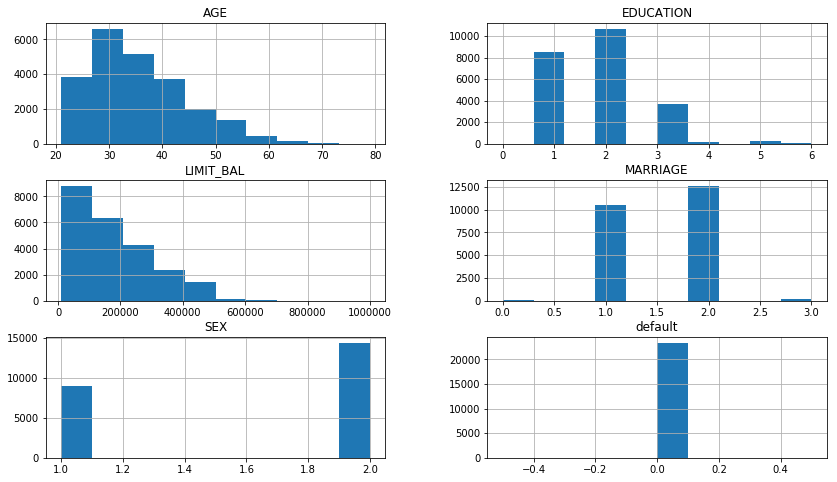

In [10]:
# Returned loan
figsize(14,8)
df_0.hist()
plt.show()

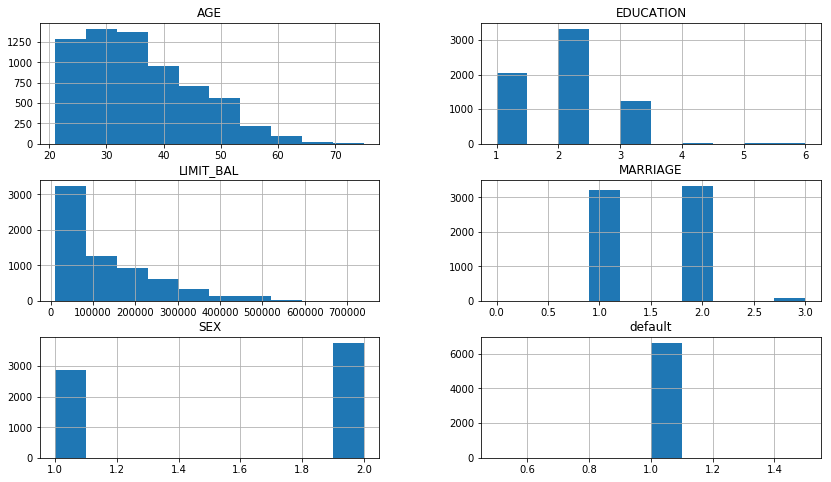

In [11]:
# Not returned loan
figsize(14,8)
df_1.hist()
plt.show()

### 1.LIMIT_BAL

In [12]:
df_0_LIMIT_BAL = df[df['default']  == 0]['LIMIT_BAL']
df_1_LIMIT_BAL = df[df['default']  == 1]['LIMIT_BAL']

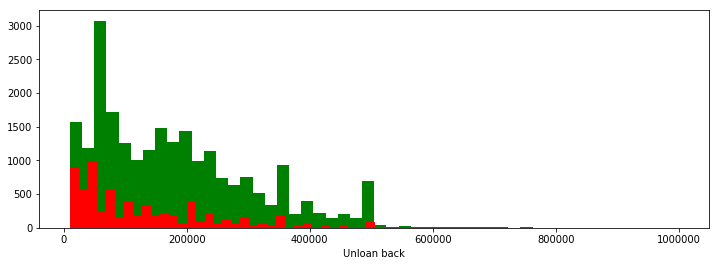

In [13]:
# Data analysis
pylab.figure(figsize=(12,4))

#pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df_0.LIMIT_BAL, color = 'g', bins=50)
pylab.xlabel('Loan back')

#pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df_1['LIMIT_BAL'], color = 'r', bins = 50)
pylab.xlabel('Unloan back')

pylab.show()

In [14]:
# Confidence interval for df_0
print ('95%% confidence interval for the mean for lock back: [%f, %f]' % zconfint(df_0['LIMIT_BAL']))

95% confidence interval for the mean for lock back: [176411.914497, 179787.537651]


In [15]:
# Confidence interval for df_1
print ('95%% confidence interval for the mean for unlock back: [%f, %f]' % zconfint(df_1['LIMIT_BAL']))

95% confidence interval for the mean for unlock back: [127333.653340, 132885.659499]


In [16]:
print ('95%% confidence interval for the mean for unlock back: [%f, %f]' % zconfint(df_1['LIMIT_BAL'], df_0['LIMIT_BAL']))

95% confidence interval for the mean for unlock back: [-51485.572278, -44494.567031]


In [17]:
# Ранговый критерий Манна-Уитни
stats.mannwhitneyu(df_0['LIMIT_BAL'], df_1['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

### Перестановочный критерий

In [18]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [19]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [20]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

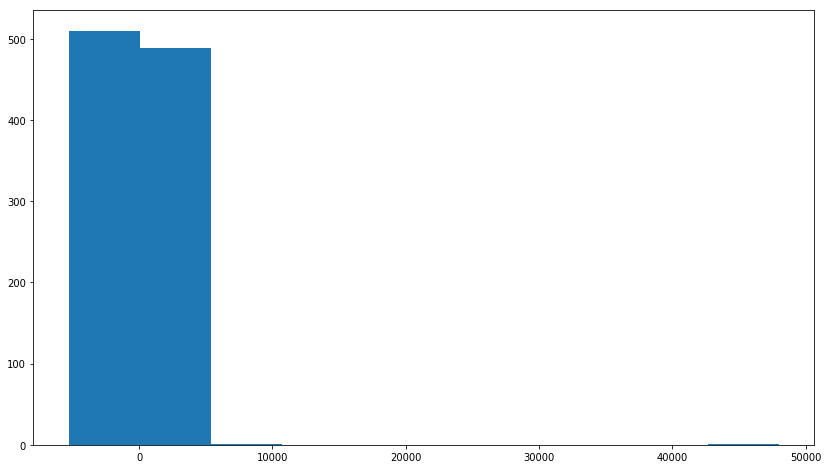

In [21]:
pylab.hist(permutation_zero_dist_ind(df_0['LIMIT_BAL'], df_1['LIMIT_BAL'], max_combinations = 1000))
pylab.show()

In [22]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [23]:
print ("p-value: %f" % permutation_test(df_0['LIMIT_BAL'], df_1['LIMIT_BAL'], max_permutations = 100))

p-value: 0.010000


## 2.SEX

In [24]:
df_0 = df[df['default'] == 0]['SEX'] # returned loan
df_1 = df[df['default'] == 1]['SEX'] # not returned loan

In [25]:
# Replace Female == 0
df_1 = df_1.replace(2,0)
df_0 = df_0.replace(2,0)
print(sum(df_1)) 
print(sum(df_0))

2873
9015


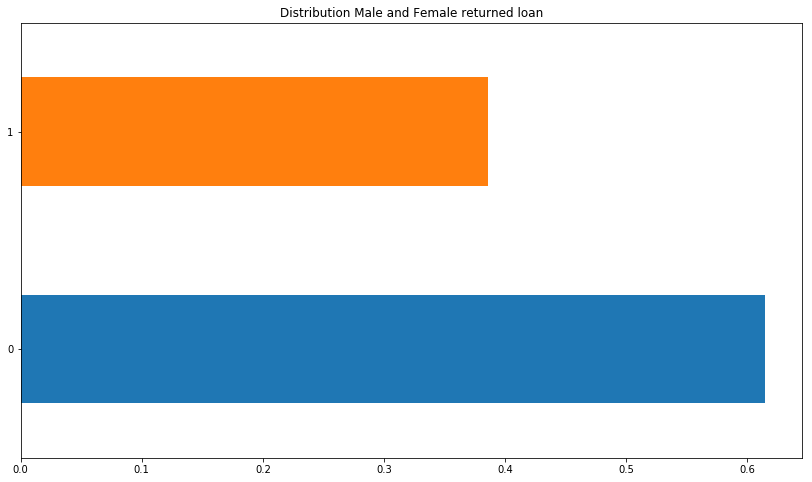

In [26]:
df_0.value_counts(1).plot.barh()
plt.title('Distribution Male and Female returned loan')
plt.show()

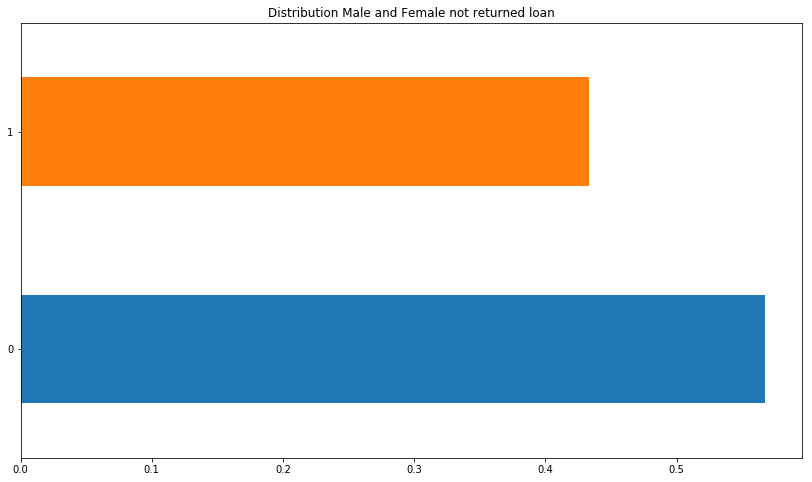

In [27]:
df_1.value_counts(1).plot.barh()
plt.title('Distribution Male and Female not returned loan')
plt.show()

In [28]:
conf_interval_turned_male = proportion_confint(sum(df_0),df_0.shape[0], method = 'wilson')
conf_interval_not_turned_male = proportion_confint(sum(df_1), df_1.shape[0], method = 'wilson')

In [29]:
print ('95%% confidence interval turned_male: [%f, %f]' % conf_interval_turned_male)
print ('95%% confidence interval not_turned_male: [%f, %f]' % conf_interval_not_turned_male)

95% confidence interval turned_male: [0.379627, 0.392110]
95% confidence interval not_turned_male: [0.421062, 0.444898]


In [30]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [31]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [32]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [33]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(df_0, df_1))

95% confidence interval for a difference between proportions: [-0.060548, -0.033635]


In [34]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df_0, df_1)))

p-value: 0.000000


In [35]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df_0, df_1), 'less'))

p-value: 0.000000


In [36]:
gender_data = df.groupby(['SEX'])
print (gender_data.mean())

      default      LIMIT_BAL  EDUCATION  MARRIAGE        AGE
SEX                                                         
1    0.241672  163519.825034   1.839250  1.572090  36.519431
2    0.207763  170086.462014   1.862246  1.538593  34.806868


## 3.EDUCATION

In [37]:
df_0_EDUCATION = df[df['default']  == 0]['EDUCATION']
df_1_EDUCATION = df[df['default']  == 1]['EDUCATION']

In [38]:
df00 = df[df['default'] == 0][df['EDUCATION'] == 0]['EDUCATION']
df01 = df[df['default'] == 0][df['EDUCATION'] == 1]['EDUCATION']
df02 = df[df['default'] == 0][df['EDUCATION'] == 2]['EDUCATION']
df03 = df[df['default'] == 0][df['EDUCATION'] == 3]['EDUCATION']
df04 = df[df['default'] == 0][df['EDUCATION'] == 4]['EDUCATION']
df05 = df[df['default'] == 0][df['EDUCATION'] == 5]['EDUCATION']
df06 = df[df['default'] == 0][df['EDUCATION'] == 6]['EDUCATION']

df10 = df[df['default'] == 1][df['EDUCATION'] == 0]['EDUCATION']
df11 = df[df['default'] == 1][df['EDUCATION'] == 1]['EDUCATION']
df12 = df[df['default'] == 1][df['EDUCATION'] == 2]['EDUCATION']
df13 = df[df['default'] == 1][df['EDUCATION'] == 3]['EDUCATION']
df14 = df[df['default'] == 1][df['EDUCATION'] == 4]['EDUCATION']
df15 = df[df['default'] == 1][df['EDUCATION'] == 5]['EDUCATION']
df16 = df[df['default'] == 1][df['EDUCATION'] == 6]['EDUCATION']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key

In [39]:
# 0
conf_interval_turned_education_0 = proportion_confint(len(df00), len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_0 = proportion_confint(len(df10), len(df_1_EDUCATION), method = 'wilson')
#1
conf_interval_turned_education_1 = proportion_confint(len(df01), len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_1 = proportion_confint(len(df11), len(df_1_EDUCATION), method = 'wilson')
#2
conf_interval_turned_education_2 = proportion_confint(len(df02), len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_2 = proportion_confint(len(df12), len(df_1_EDUCATION), method = 'wilson')
#3
conf_interval_turned_education_3 = proportion_confint(len(df03), len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_3 = proportion_confint(len(df13), len(df_1_EDUCATION), method = 'wilson')
#4
conf_interval_turned_education_4 = proportion_confint(len(df04),len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_4 = proportion_confint(len(df14), len(df_1_EDUCATION), method = 'wilson')
#5
conf_interval_turned_education_5 = proportion_confint(len(df05), len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_5 = proportion_confint(len(df15), len(df_1_EDUCATION), method = 'wilson')
#6
conf_interval_turned_education_6 = proportion_confint(len(df06), len(df_0_EDUCATION), method = 'wilson')
conf_interval_not_turned_education_6 = proportion_confint(len(df16), len(df_1_EDUCATION), method = 'wilson')



In [40]:
print ('95%% confidence interval turned_education_0: [%f, %f]' % conf_interval_turned_education_0)
print ('95%% confidence interval not turned_education_0: [%f, %f]' % conf_interval_not_turned_education_0)
print('')
print ('95%% confidence interval turned_education_1: [%f, %f]' % conf_interval_turned_education_1)
print ('95%% confidence interval not turned_education_1: [%f, %f]' % conf_interval_not_turned_education_1)
print('')
print ('95%% confidence interval turned_education_2: [%f, %f]' % conf_interval_turned_education_2)
print ('95%% confidence interval not turned_education_2: [%f, %f]' % conf_interval_not_turned_education_2)
print('')
print ('95%% confidence interval turned_education_3: [%f, %f]' % conf_interval_turned_education_3)
print ('95%% confidence interval not turned_education_3: [%f, %f]' % conf_interval_not_turned_education_3)
print('')
print ('95%% confidence interval turned_education_4: [%f, %f]' % conf_interval_turned_education_4)
print ('95%% confidence interval not turned_education_4: [%f, %f]' % conf_interval_not_turned_education_4)
print('')
print ('95%% confidence interval turned_education_5: [%f, %f]' % conf_interval_turned_education_5)
print ('95%% confidence interval not turned_education_5: [%f, %f]' % conf_interval_not_turned_education_5)
print('')
print ('95%% confidence interval turned_education_6: [%f, %f]' % conf_interval_turned_education_6)
print ('95%% confidence interval not turned_education_6: [%f, %f]' % conf_interval_not_turned_education_6)



95% confidence interval turned_education_0: [0.000357, 0.001006]
95% confidence interval not turned_education_0: [0.000000, 0.000579]

95% confidence interval turned_education_1: [0.359751, 0.372103]
95% confidence interval not turned_education_1: [0.295830, 0.318016]

95% confidence interval turned_education_2: [0.451588, 0.464364]
95% confidence interval not turned_education_2: [0.489781, 0.513834]

95% confidence interval turned_education_3: [0.152893, 0.162235]
95% confidence interval not turned_education_3: [0.177220, 0.195958]

95% confidence interval turned_education_4: [0.004141, 0.005951]
95% confidence interval not turned_education_4: [0.000511, 0.002176]

95% confidence interval turned_education_5: [0.009942, 0.012647]
95% confidence interval not turned_education_5: [0.001717, 0.004284]

95% confidence interval turned_education_6: [0.001367, 0.002478]
95% confidence interval not turned_education_6: [0.000611, 0.002377]


In [41]:
education_data = df.groupby(['EDUCATION'])
print (education_data.mean())

            default      LIMIT_BAL       SEX  MARRIAGE        AGE
EDUCATION                                                        
0          0.000000  217142.857143  1.428571  1.714286  38.857143
1          0.192348  212956.069910  1.588663  1.652338  34.231838
2          0.237349  147062.437634  1.616964  1.523022  34.722096
3          0.251576  126550.270490  1.595282  1.421192  40.299980
4          0.056911  220894.308943  1.658537  1.601626  33.853659
5          0.064286  168164.285714  1.660714  1.475000  35.600000
6          0.156863  148235.294118  1.509804  1.490196  43.901961


In [42]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [43]:
df4 = pd.DataFrame({"0": [len(df00)/len(df_0_EDUCATION), len(df10)/len(df_1_EDUCATION)],
                   "1":[len(df01)/len(df_0_EDUCATION), len(df11)/len(df_1_EDUCATION)],
                   "2": [len(df02)/len(df_0_EDUCATION), len(df12)/len(df_1_EDUCATION)],
                    "3":[len(df03)/len(df_0_EDUCATION), len(df13)/len(df_1_EDUCATION)],
                   "4": [len(df04)/len(df_0_EDUCATION), len(df14)/len(df_1_EDUCATION)],
                  "5": [len(df05)/len(df_0_EDUCATION), len(df15)/len(df_1_EDUCATION)],
                   "6": [len(df06)/len(df_0_EDUCATION), len(df16)/len(df_1_EDUCATION)]})

In [44]:
round(df4,3)

,0,1,2,3,4,5,6
0,0.001,0.366,0.458,0.158,0.005,0.011,0.002
1,0.000,0.307,0.502,0.186,0.001,0.003,0.001


In [45]:
df4 = df4.transpose()

In [46]:
sum(df4)

0    1.0
1    1.0
dtype: float64

In [47]:
round(sum(df4),3)

0    1.0
1    1.0
dtype: float64

In [48]:
df41 = pd.DataFrame({"0": [len(df00)/(len(df00)+ len(df10)), len(df10)/(len(df00)+ len(df10))],
                   "1":[len(df01)/(len(df01)+ len(df11)), len(df11)/(len(df01)+ len(df11))],
                   "2": [len(df02)/(len(df02)+ len(df12)), len(df12)/(len(df02)+ len(df12))],
                    "3":[len(df03)/(len(df03)+ len(df13)), len(df13)/(len(df03)+ len(df13))],
                   "4": [len(df04)/(len(df04)+ len(df14)), len(df14)/(len(df04)+ len(df14))],
                  "5": [len(df05)/(len(df05)+ len(df15)), len(df15)/(len(df05)+ len(df15))],
                   "6": [len(df06)/(len(df06)+ len(df16)), len(df16)/(len(df06)+ len(df16))]})
round(df41,3)

,0,1,2,3,4,5,6
0,1.0,0.808,0.763,0.748,0.943,0.936,0.843
1,0.0,0.192,0.237,0.252,0.057,0.064,0.157


## 4. MARRIAGE

In [49]:
df_0_MARRIAGE = df[df['default']  == 0]['MARRIAGE']
df_1_MARRIAGE = df[df['default']  == 1]['MARRIAGE']
print(len(df[df['default']  == 0]), len(df_1_MARRIAGE))

23364 6636


In [50]:
print(df_0_MARRIAGE.value_counts())
print(df_1_MARRIAGE.value_counts())

2    12623
1    10453
3      239
0       49
Name: MARRIAGE, dtype: int64
2    3341
1    3206
3      84
0       5
Name: MARRIAGE, dtype: int64


In [51]:
#0
df_marriage_00 = df[df['default'] == 0][df['MARRIAGE'] == 0]['MARRIAGE']
df_marriage_01 = df[df['default'] == 1][df['MARRIAGE'] == 0]['MARRIAGE']
#1
df_marriage_10 = df[df['default'] == 0][df['MARRIAGE'] == 1]['MARRIAGE']
df_marriage_11 = df[df['default'] == 1][df['MARRIAGE'] == 1]['MARRIAGE']
#2
df_marriage_20 = df[df['default'] == 0][df['MARRIAGE'] == 2]['MARRIAGE']
df_marriage_21 = df[df['default'] == 1][df['MARRIAGE'] == 2]['MARRIAGE']
#3
df_marriage_30 = df[df['default'] == 0][df['MARRIAGE'] == 3]['MARRIAGE']
df_marriage_31 = df[df['default'] == 1][df['MARRIAGE'] == 3]['MARRIAGE']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Program

In [52]:
len(df_marriage_21)

3341

In [53]:
df_table_marriage = pd.DataFrame({"0": [len(df_marriage_00)/df_0.shape[0], len(df_marriage_01)/df_1.shape[0]],
                   "1":[len(df_marriage_10)/df_0.shape[0], len(df_marriage_11)/df_1.shape[0]],
                   "2": [len(df_marriage_20)/df_0.shape[0], len(df_marriage_21)/df_1.shape[0]],
                    "3":[len(df_marriage_30)/df_0.shape[0], len(df_marriage_31)/df_1.shape[0]]})
df_table_marriage

,0,1,2,3
0,0.002097,0.447398,0.540276,0.010229
1,0.000753,0.483122,0.503466,0.012658


In [54]:
# 0
conf_interval_turned_marriage_0 = proportion_confint(len(df_marriage_00), df_0.shape[0], method = 'wilson')
conf_interval_not_turned_marriage_0 = proportion_confint(len(df_marriage_01), df_1.shape[0], method = 'wilson')
#1
conf_interval_turned_marriage_1 = proportion_confint(len(df_marriage_10), df_0.shape[0], method = 'wilson')
conf_interval_not_turned_marriage_1 = proportion_confint(len(df_marriage_11), df_1.shape[0], method = 'wilson')
#2
conf_interval_turned_marriage_2 = proportion_confint(len(df_marriage_20), df_0.shape[0], method = 'wilson')
conf_interval_not_turned_marriage_2 = proportion_confint(len(df_marriage_21), df_1.shape[0], method = 'wilson')
#3
conf_interval_turned_marriage_3 = proportion_confint(len(df_marriage_30), df_0.shape[0], method = 'wilson')
conf_interval_not_turned_marriage_3 = proportion_confint(len(df_marriage_31), df_1.shape[0], method = 'wilson')

In [55]:
print ('95%% confidence interval turned_education_0: [%f, %f]' % conf_interval_turned_marriage_0)
print ('95%% confidence interval not turned_education_0: [%f, %f]' % conf_interval_not_turned_marriage_0)
print('')
print ('95%% confidence interval turned_education_0: [%f, %f]' % conf_interval_turned_marriage_1)
print ('95%% confidence interval not turned_education_0: [%f, %f]' % conf_interval_not_turned_marriage_1)
print('')
print ('95%% confidence interval turned_education_0: [%f, %f]' % conf_interval_turned_marriage_2)
print ('95%% confidence interval not turned_education_0: [%f, %f]' % conf_interval_not_turned_marriage_2)
print('')
print ('95%% confidence interval turned_education_0: [%f, %f]' % conf_interval_turned_marriage_3)
print ('95%% confidence interval not turned_education_0: [%f, %f]' % conf_interval_not_turned_marriage_3)

95% confidence interval turned_education_0: [0.001587, 0.002771]
95% confidence interval not turned_education_0: [0.000322, 0.001763]

95% confidence interval turned_education_0: [0.441031, 0.453782]
95% confidence interval not turned_education_0: [0.471112, 0.495152]

95% confidence interval turned_education_0: [0.533879, 0.546659]
95% confidence interval not turned_education_0: [0.491438, 0.515490]

95% confidence interval turned_education_0: [0.009017, 0.011603]
95% confidence interval not turned_education_0: [0.010236, 0.015644]


In [56]:
stats.mannwhitneyu(df_marriage_30, df_0_MARRIAGE)

MannwhitneyuResult(statistic=28560.5, pvalue=3.2584540605258184e-201)

In [57]:
print ("p-value: %f" % permutation_test(df_0_MARRIAGE, df_1_MARRIAGE, max_permutations = 1000))

p-value: 0.001000


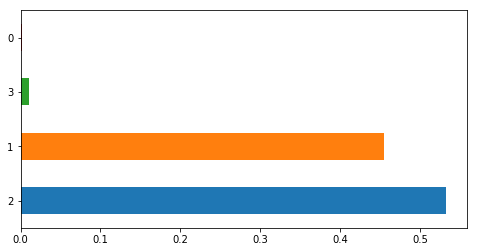

In [58]:
pylab.figure(figsize=(8,4))
df['MARRIAGE'].value_counts(1).plot.barh()
plt.show()

## 5.AGE

In [59]:
df_0_AGE = df[df['default']  == 0]['AGE']
df_1_AGE = df[df['default']  == 1]['AGE']

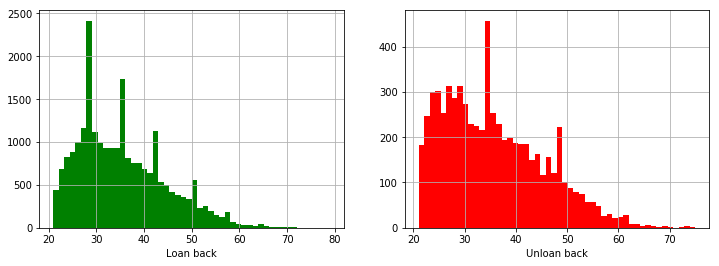

In [60]:
# Data analysis
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df_0_AGE, color = 'g', bins=50)
pylab.xlabel('Loan back')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df_1_AGE, color = 'r', bins = 50)
pylab.xlabel('Unloan back')

pylab.show()

In [61]:
# Confidence interval for df_0_AGE
print ('95%% confidence interval for the mean for lock back: [%f, %f]' % zconfint(df_0_AGE))
# Confidence interval for df_1_AGE
print ('95%% confidence interval for the mean for unlock back: [%f, %f]' % zconfint(df_1_AGE))

95% confidence interval for the mean for lock back: [35.300871, 35.533661]
95% confidence interval for the mean for unlock back: [35.492515, 35.958962]


In [62]:
# Ранговый критерий Манна-Уитни
stats.mannwhitneyu(df_0_AGE, df_1_AGE)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

### Commutation criterion

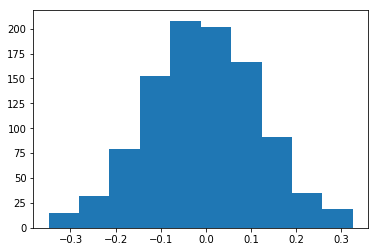

In [63]:
figsize(6,4)
pylab.hist(permutation_zero_dist_ind(df_0_AGE, df_1_AGE, max_combinations = 1000))
pylab.show()

In [64]:
print ("p-value: %f" % permutation_test(df_0_AGE, df_1_AGE, max_permutations = 1000))

p-value: 0.013000


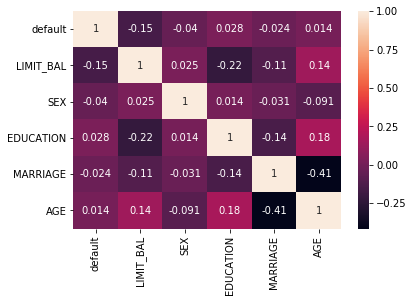

In [65]:
sns.heatmap(df.corr(), annot=True)